In [1]:
import mne 
import scipy.io
import numpy as np
import mne
from mne.io import RawArray
from mne import create_info
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
%matplotlib notebook
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

In [2]:
raw = mne.io.read_raw_fif(r"C:\Users\sonam\University of Canberra\4th Semester\Capstone\dataset\eeg_raw_fif\cz_eeg1_raw.fif", preload = True)

Opening raw data file C:\Users\sonam\University of Canberra\4th Semester\Capstone\dataset\eeg_raw_fif\cz_eeg1_raw.fif...
    Range : 0 ... 33600 =      0.000 ...    33.600 secs
Ready.
Reading 0 ... 33600  =      0.000 ...    33.600 secs...


In [3]:
raw.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,65 points
Good channels,62 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.00 Hz
Lowpass,500.00 Hz


In [4]:
duration_seconds = raw.n_times / raw.info['sfreq']
print("Duration of the raw EEG data:", duration_seconds, "seconds")

Duration of the raw EEG data: 33.601 seconds


# 1. Artifact Detection

In [5]:
ssp_projectors = raw.info["projs"]
raw.del_proj()

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,65 points
Good channels,62 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.00 Hz
Lowpass,500.00 Hz


# 3. Filtering and resampling data
A filter removes or attenuates parts of a signal. Usually, filters act on specific frequency ranges of a signal — for example, suppressing all frequency components above or below a certain cutoff value. 

### 3.3 Resampling

Downsampling is typically performed during the preprocessing stage of EEG data analysis, often after initial filtering and artifact removal steps. 

In [6]:
raw_downsampled = raw.copy().resample(sfreq=200)
raw_downsampled.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,65 points
Good channels,62 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


In [7]:
print(raw_downsampled)

<Raw | cz_eeg1_raw.fif, 62 x 6720 (33.6 s), ~3.3 MB, data loaded>


Effective window size : 2.048 (s)


<IPython.core.display.Javascript object>


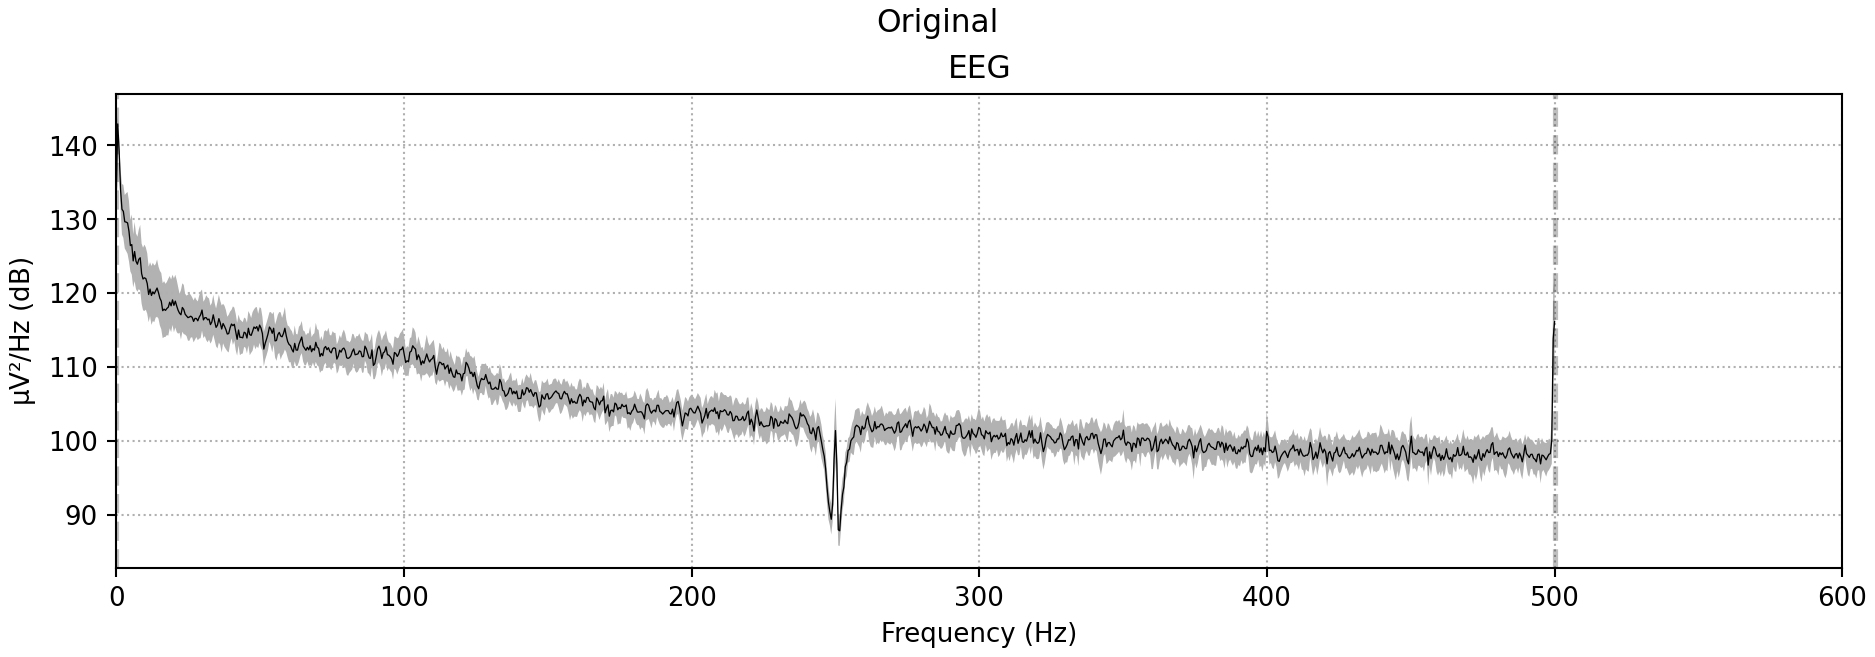

Effective window size : 10.240 (s)


<IPython.core.display.Javascript object>


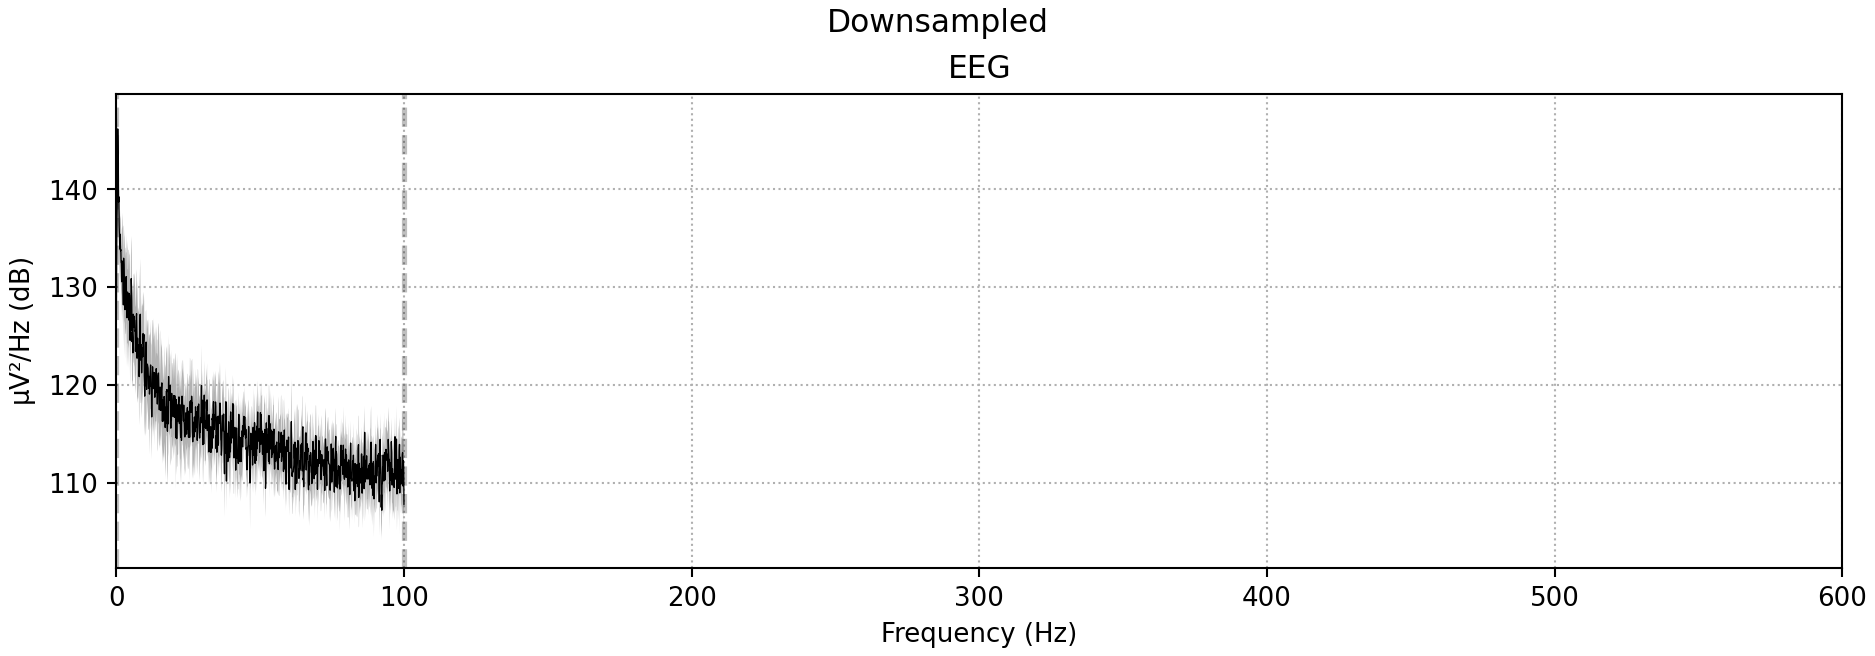

In [8]:
# Compare original data with downsampled data

for data, title in zip([raw, raw_downsampled], ["Original", "Downsampled"]):
    fig = data.compute_psd().plot(average=True, picks="data", exclude="bads")
    fig.suptitle(title)
    plt.setp(fig.axes, xlim=(0, 600))

<!-- ### High-Pass Filter: 
A high-pass filter is a signal processing filter that attenuates or removes low-frequency components from a signal while allowing high-frequency components to pass through. In the context of EEG data analysis, applying a high-pass filter helps remove slow drifts and baseline fluctuations from the EEG signal, which are often caused by non-neural sources such as electrode drift, movement artifacts, or physiological processes like respiration and cardiac activity. -->

## Bandpass Filter

In [9]:

# only keeping frequencies between 0.5-42 Hz
raw_downsampled_bandpass= raw_downsampled.filter(l_freq=0.5, h_freq=42.0) 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 42 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 42.00 Hz
- Upper transition bandwidth: 10.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    0.0s finished


In [10]:
print(raw_downsampled_bandpass)

<Raw | cz_eeg1_raw.fif, 62 x 6720 (33.6 s), ~3.3 MB, data loaded>


In [11]:
df= raw_downsampled_bandpass.to_data_frame()
df

,time,FP1,FPZ,FP2,AF3,AF4,F7,F5,F3,F1,...,PO3,POZ,PO4,PO6,PO8,CB1,O1,OZ,O2,CB2
0,0.000,-2.081668e-09,5.273559e-10,3.608225e-10,2.886580e-09,-9.159340e-10,6.050715e-09,2.553513e-09,1.582068e-09,5.689893e-09,...,6.897261e-09,3.608225e-10,5.884182e-09,2.803313e-09,3.747003e-09,5.134781e-09,2.095546e-09,7.188694e-09,-5.551115e-11,5.051515e-09
1,0.005,5.497661e+06,3.937600e+05,-2.184288e+06,2.865200e+06,1.598533e+06,1.585172e+07,-5.696711e+05,-1.521111e+04,1.685651e+06,...,1.734980e+07,8.037958e+06,2.023391e+06,5.525938e+06,7.559521e+06,1.617013e+07,1.733605e+07,1.639449e+07,9.173436e+06,1.396510e+07
2,0.010,2.011813e+07,1.555276e+07,1.412187e+07,7.024494e+06,1.252114e+07,2.164580e+07,6.489831e+05,1.472688e+06,4.253405e+06,...,1.940875e+07,8.674977e+06,9.885282e+05,5.724298e+06,8.217806e+06,1.796419e+07,1.943644e+07,1.967932e+07,1.050928e+07,1.657908e+07
3,0.015,5.163099e+07,5.223400e+07,5.385380e+07,1.612990e+07,3.526094e+07,2.211448e+07,6.892373e+06,7.688415e+06,1.097239e+07,...,6.820000e+06,1.169207e+06,-4.849445e+06,-1.667196e+06,-1.637564e+05,5.740782e+06,6.850689e+06,9.507200e+06,1.773728e+06,4.985811e+06
4,0.020,9.517340e+07,9.989956e+07,1.019738e+08,3.070998e+07,6.162005e+07,2.862270e+07,1.832380e+07,1.899649e+07,2.256242e+07,...,-7.273806e+06,-8.601159e+06,-1.394634e+07,-1.354709e+07,-1.326872e+07,-8.234393e+06,-7.353882e+06,-3.491791e+06,-1.203024e+07,-1.297997e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6715,33.575,3.248963e+07,2.892470e+07,2.776754e+07,1.234759e+07,1.773267e+07,1.208014e+07,9.096176e+06,8.810858e+06,8.349242e+06,...,-1.389024e+06,1.480921e+06,6.561977e+05,6.497793e+05,-2.202674e+06,-1.523957e+06,-1.530295e+06,4.892654e+04,-1.604337e+06,-5.346305e+06
6716,33.580,2.375345e+07,2.138337e+07,2.054171e+07,1.143754e+07,1.442768e+07,9.289784e+06,8.602627e+06,8.398297e+06,8.013511e+06,...,1.740927e+06,4.164075e+06,3.396894e+06,4.219936e+06,4.995654e+05,1.506875e+06,1.545678e+06,3.329942e+06,2.904842e+06,-1.211314e+06
6717,33.585,1.460512e+07,1.406198e+07,1.344204e+07,7.974690e+06,9.187719e+06,4.852274e+06,6.338362e+06,6.148660e+06,5.875502e+06,...,5.302741e+06,4.987242e+06,4.360780e+06,6.634595e+06,3.874131e+06,4.808709e+06,4.967581e+06,6.043312e+06,6.007012e+06,2.716789e+06
6718,33.590,6.944778e+06,7.306990e+06,6.923099e+06,3.786920e+06,4.183121e+06,1.513624e+06,3.228382e+06,3.084197e+06,2.944967e+06,...,5.020324e+06,3.341669e+06,2.976778e+06,5.126975e+06,3.982059e+06,4.561255e+06,4.726444e+06,4.985293e+06,4.883195e+06,3.195241e+06


In [12]:
np_raw = raw_downsampled.get_data()

In [13]:
np_raw.shape

(62, 6720)

In [14]:
print(np_raw)

[[-2.08166817e-15  5.49766097e+00  2.01181287e+01 ...  1.46051221e+01
   6.94477753e+00  1.06581410e-14]
 [ 5.27355937e-16  3.93760027e-01  1.55527593e+01 ...  1.40619835e+01
   7.30698974e+00 -3.55271368e-15]
 [ 3.60822483e-16 -2.18428827e+00  1.41218652e+01 ...  1.34420370e+01
   6.92309948e+00  2.13162821e-14]
 ...
 [ 7.18869408e-15  1.63944924e+01  1.96793236e+01 ...  6.04331230e+00
   4.98529304e+00  5.32907052e-15]
 [-5.55111512e-17  9.17343622e+00  1.05092774e+01 ...  6.00701190e+00
   4.88319455e+00  8.88178420e-15]
 [ 5.05151476e-15  1.39651004e+01  1.65790798e+01 ...  2.71678934e+00
   3.19524113e+00 -3.55271368e-15]]


In [15]:
# Additional information
session_no = np.full(len(np_raw), 1)  # Example session numbers
participant = np.full(len(np_raw), "cz_eeg_1")  # Example participant names
emotion_label = np.full(len(np_raw), "0")  # Example emotion labels

# Concatenate additional information with EEG signal array
data_with_info = np.column_stack((session_no, participant, emotion_label, np_raw))

# Save to CSV file
np.savetxt("test3.csv", data_with_info, delimiter=",", fmt='%s')

In [16]:
# Load the CSV file
data_with_info = np.genfromtxt("test3.csv", delimiter=",", dtype=str)

# Extract EEG signal array (excluding additional columns)
eeg_signal = data_with_info[:, 3:].astype(float)

# Print or use the EEG signal array
eeg_signal.shape

(62, 6720)

<IPython.core.display.Javascript object>


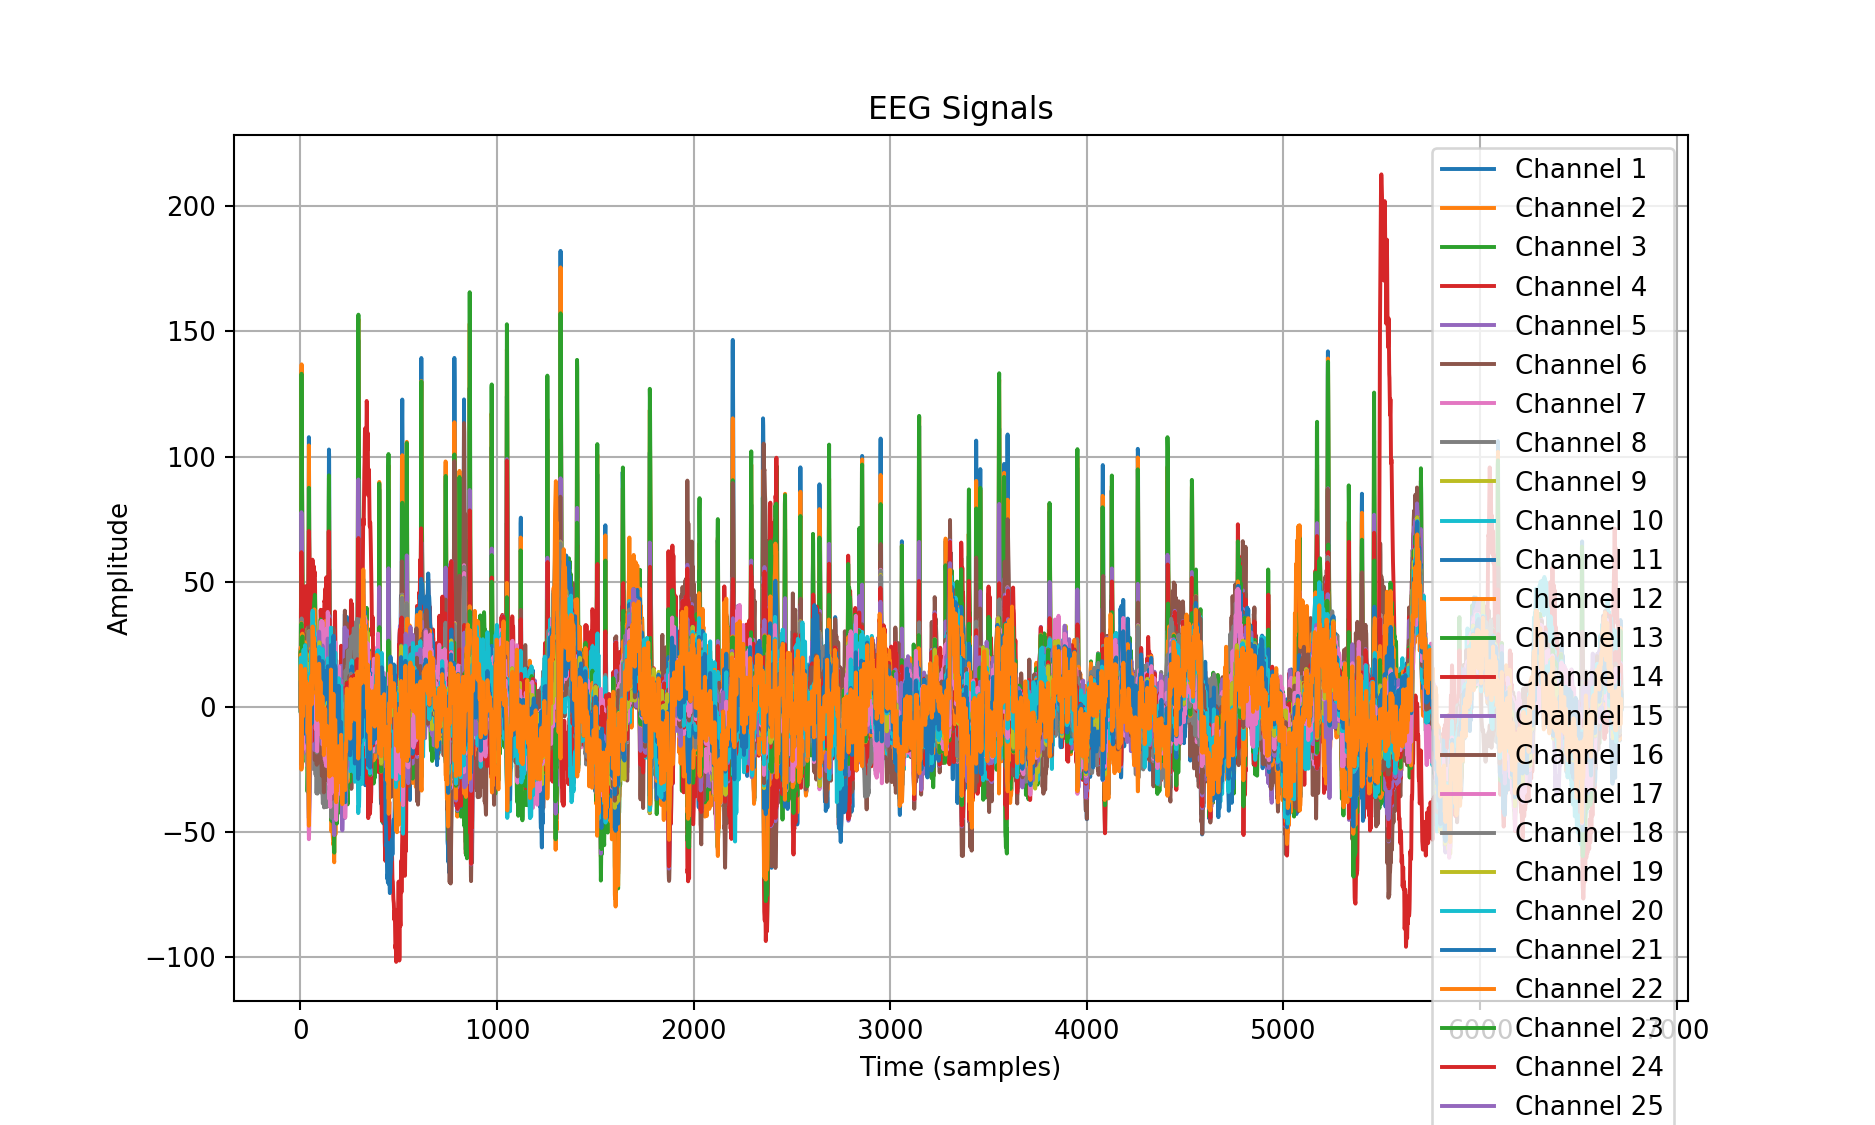

In [17]:
# Plot EEG signals
plt.figure(figsize=(10, 6))
num_samples = len(eeg_signal[0])  # Number of samples
time = np.arange(num_samples)  # Time axis in samples

for i in range(len(eeg_signal)):
    plt.plot(time, eeg_signal[i], label=f"Channel {i+1}")

plt.title("EEG Signals")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()